<a href="https://colab.research.google.com/github/Kvedhik1997/Netflix-Film-Clustering/blob/main/Clustering_Algorithms_for_Netflix_Film_Suggestions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction: 

Netflix is the largest streaming service provider in the world and a lot of data science goes into it to make the service ideal for consumers. One such way data science is utilized is by providing suggestions on films based on the consumer’s watch history. I will be looking into which clustering algorithms and dimensionality reduction techniques are the most useful for separating films by their various attributes

Hypotheses:

H01: There is no significant difference in using PCA, t-SNE, or UMAP for dimensionality   reduction in the netflix dataset?
HA1: There is a significant difference in using PCA, t-SNE, or UMAP for dimensionality   reduction in the netflix dataset?

H02: There is no significant clustering when using K-means, Agglomerative clustering, or Gaussian Mixtures to cluster the dimension-reduced netflix dataset?
H03: There is no significant clustering when using K-means, Agglomerative clustering, or Gaussian Mixtures to cluster the dimension-reduced netflix dataset?

Data:

The data consists of 7,887 movies and tv shows available on netflix through July 2021.  The 12 features in this data set are composed of categorical variables and will need to be modified to perform any clustering algorithms. This is also an unlabeled data set, so there is no ground truth. The features on this data set are: show id, type (Movie or TV show), title, director, cast, country, date added to netflix, released year, rating, duration, genre, and description.


In [1]:
!pip install umap-learn
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from google.colab import files
import io

In [2]:
file=files.upload()

Saving netflix_titles.csv to netflix_titles (1).csv


In [3]:
netflix=pd.read_csv(io.BytesIO(file['netflix_titles.csv']))

In [4]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [6]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


Methods:

I first cleaned the data to only include the important features by dropping the show ID, title, director, date added to netflix, duration, and description features. I also turned the cast, countries, unique genres, released year, and rating into dummy columns. There are 32,881 unique cast members, so creating dummy columns for every single one would provide poor clustering and too much interference given that most actors had very few films on netflix. To combat this, I only included dummy columns for actors that were cast in 15 unique titles. This gave 53 dummy columns. The same method was performed for countries as well to include only the top 17 countries by title count. I created dummy columns for the released year based on ranges of years: <2000, 2001-2005, 2006-2010, 2011-2015, and >2016. For the genres and ratings, I created dummy columns for every genre and rating.


In [7]:
#too many unique directors with not enough movies per director to provide significant clustering ability
netflix['director'].value_counts()

Raúl Campos, Jan Suter    18
Marcus Raboy              16
Jay Karas                 14
Cathy Garcia-Molina       13
Jay Chapman               12
                          ..
Jon Manning                1
Ketche                     1
Monica Floyd               1
D Ho                       1
Roland Emmerich            1
Name: director, Length: 4049, dtype: int64

In [8]:
cast=(netflix['cast'].unique())

cast_cleaned=[]
for i in range(len(cast)):
  try:
    cast[i]=cast[i].split(', ')
    for j in cast[i]:
      cast_cleaned.append(j) 

  except:
    continue

unique_cast=[]
for i in cast_cleaned:
  if i not in unique_cast:
    unique_cast.append(i)
  else:
    continue

In [9]:
#there are way too many unique cast members for significance in clustering
len(unique_cast)

32881

In [10]:
#we'll only include the most popular actors on netflix with greater than 15 movies on netflix
import collections
collections.Counter(cast_cleaned).most_common()

[('Anupam Kher', 42),
 ('Shah Rukh Khan', 35),
 ('Naseeruddin Shah', 30),
 ('Om Puri', 30),
 ('Akshay Kumar', 29),
 ('Takahiro Sakurai', 28),
 ('Boman Irani', 27),
 ('Amitabh Bachchan', 27),
 ('Paresh Rawal', 27),
 ('Yuki Kaji', 26),
 ('Kareena Kapoor', 25),
 ('John Cleese', 23),
 ('Vincent Tong', 23),
 ('Tara Strong', 22),
 ('Andrea Libman', 22),
 ('Ajay Devgn', 21),
 ('Samuel L. Jackson', 20),
 ('Kay Kay Menon', 20),
 ('Salman Khan', 20),
 ('Ashleigh Ball', 20),
 ('Nicolas Cage', 20),
 ('Fred Tatasciore', 19),
 ('Gulshan Grover', 19),
 ('Adam Sandler', 19),
 ('Daisuke Ono', 19),
 ('Nawazuddin Siddiqui', 19),
 ('Erin Fitzgerald', 18),
 ('Ai Kayano', 18),
 ('Yashpal Sharma', 18),
 ('Anil Kapoor', 18),
 ('Debi Derryberry', 18),
 ('James Franco', 18),
 ('Jackie Shroff', 17),
 ('Priyanka Chopra', 17),
 ('Saif Ali Khan', 17),
 ('Fred Armisen', 17),
 ('Kate Higgins', 17),
 ('Kana Hanazawa', 17),
 ('Junichi Suwabe', 17),
 ('Asrani', 17),
 ('Laura Bailey', 17),
 ('Danny Trejo', 16),
 ('Aamir 

In [11]:
count=0
while collections.Counter(cast_cleaned).most_common()[count][1]>15:
  count+=1
count

53

In [12]:
collections.Counter(cast_cleaned).most_common()[52]

('Robb Wells', 16)

In [13]:
actors=collections.Counter(cast_cleaned).most_common()[0:53]
top_actors=[]
for i in range(len(actors)):
  top_actors.append(actors[i][0])


In [14]:
#There are too many
netflix['country'].value_counts()[0:17]

United States     2555
India              923
United Kingdom     397
Japan              226
South Korea        183
Canada             177
Spain              134
France             115
Egypt              101
Mexico             100
Turkey             100
Australia           83
Taiwan              78
Brazil              72
Philippines         71
Nigeria             70
Indonesia           70
Name: country, dtype: int64

In [15]:
countries=netflix['country'].value_counts().index[0:17]


In [16]:
netflix['listed_in'][0]

'International TV Shows, TV Dramas, TV Sci-Fi & Fantasy'

In [17]:
genres=netflix['listed_in']
genres_cleaned=[]
for i in range(len(genres)):
  for j in genres[i].split(', '):
    genres_cleaned.append(j) 

collections.Counter(genres_cleaned).most_common()

[('International Movies', 2437),
 ('Dramas', 2106),
 ('Comedies', 1471),
 ('International TV Shows', 1199),
 ('Documentaries', 786),
 ('Action & Adventure', 721),
 ('TV Dramas', 704),
 ('Independent Movies', 673),
 ('Children & Family Movies', 532),
 ('Romantic Movies', 531),
 ('TV Comedies', 525),
 ('Thrillers', 491),
 ('Crime TV Shows', 427),
 ("Kids' TV", 414),
 ('Docuseries', 353),
 ('Romantic TV Shows', 333),
 ('Stand-Up Comedy', 329),
 ('Music & Musicals', 321),
 ('Horror Movies', 312),
 ('British TV Shows', 232),
 ('Reality TV', 222),
 ('Sci-Fi & Fantasy', 218),
 ('Sports Movies', 196),
 ('Korean TV Shows', 150),
 ('TV Action & Adventure', 150),
 ('Anime Series', 148),
 ('Spanish-Language TV Shows', 147),
 ('Classic Movies', 103),
 ('TV Mysteries', 90),
 ('LGBTQ Movies', 90),
 ('Science & Nature TV', 85),
 ('TV Sci-Fi & Fantasy', 76),
 ('TV Horror', 69),
 ('Teen TV Shows', 60),
 ('Cult Movies', 59),
 ('Faith & Spirituality', 57),
 ('Anime Features', 57),
 ('Movies', 56),
 ('Stan

In [18]:
unique_genres=[]
for i in range(len(genres_cleaned)):
  if genres_cleaned[i] not in unique_genres and 'TV' not in genres_cleaned[i]:
    unique_genres.append(genres_cleaned[i])

In [19]:
unique_genres

['Dramas',
 'International Movies',
 'Horror Movies',
 'Action & Adventure',
 'Independent Movies',
 'Sci-Fi & Fantasy',
 'Thrillers',
 'Docuseries',
 'Documentaries',
 'Sports Movies',
 'Comedies',
 'Anime Series',
 'Romantic Movies',
 'Movies',
 'Music & Musicals',
 'LGBTQ Movies',
 'Faith & Spirituality',
 'Children & Family Movies',
 'Classic Movies',
 'Cult Movies',
 'Stand-Up Comedy & Talk Shows',
 'Stand-Up Comedy',
 'Anime Features']

In [20]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [21]:
cols=netflix.columns

In [22]:
for i in unique_genres:
  netflix[i]=0
for i in top_actors:
  netflix[i]=0
for i in countries:
  netflix[i]=0
netflix['<=2000']=0
netflix['2001-2005']=0
netflix['2006-2010']=0
netflix['2011-2015']=0
netflix['>=2015']=0

for i in range(len(netflix)):
  for j in unique_genres:
    if j in netflix['listed_in'][i]:
      netflix[j][i]=1
    else:
      continue
  for j in top_actors:
    try:
      if j in netflix['cast'][i]:
        netflix[j][i]=1
      else:
        continue
    except:
      continue

      
  for j in countries:
    if j in netflix['listed_in'][i]:
      netflix[j][i]=1
    else:
      continue
  if netflix['release_year'][i] <= 2000:
    netflix['<=2000'][i]=1
  else:
    continue
  if netflix['release_year'][i] > 2000 and netflix['release_year'][i] < 2006:
    netflix['<=2000'][i]=1
  else:
    continue
  if netflix['release_year'][i] > 2005 and netflix['release_year'][i] < 2011:
    netflix['<=2000'][i]=1
  else:
    continue
  if netflix['release_year'][i] > 2010 and netflix['release_year'][i] < 2016:
    netflix['<=2000'][i]=1
  else:
    continue
  if netflix['release_year'][i] > 2015:
    netflix['<=2000'][i]=1
  else:
    continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
netflix=pd.concat([netflix, pd.get_dummies(netflix['rating'], prefix='rating')], axis=1)
netflix=pd.concat([netflix, pd.get_dummies(netflix['type'])], axis=1)

In [24]:
netflix=netflix.drop(cols, axis=1)


In [25]:
netflix


,Dramas,International Movies,Horror Movies,Action & Adventure,Independent Movies,Sci-Fi & Fantasy,Thrillers,Docuseries,Documentaries,Sports Movies,Comedies,Anime Series,Romantic Movies,Movies,Music & Musicals,LGBTQ Movies,Faith & Spirituality,Children & Family Movies,Classic Movies,Cult Movies,Stand-Up Comedy & Talk Shows,Stand-Up Comedy,Anime Features,Anupam Kher,Shah Rukh Khan,Naseeruddin Shah,Om Puri,Akshay Kumar,Takahiro Sakurai,Boman Irani,Amitabh Bachchan,Paresh Rawal,Yuki Kaji,Kareena Kapoor,John Cleese,Vincent Tong,Tara Strong,Andrea Libman,Ajay Devgn,Samuel L. Jackson,...,Hassan Hosny,Robb Wells,United States,India,United Kingdom,Japan,South Korea,Canada,Spain,France,Egypt,Mexico,Turkey,Australia,Taiwan,Brazil,Philippines,Nigeria,Indonesia,<=2000,2001-2005,2006-2010,2011-2015,>=2015,rating_G,rating_NC-17,rating_NR,rating_PG,rating_PG-13,rating_R,rating_TV-14,rating_TV-G,rating_TV-MA,rating_TV-PG,rating_TV-Y,rating_TV-Y7,rating_TV-Y7-FV,rating_UR,Movie,TV Show
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7783,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
7784,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7785,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


Results:

Based on visual inspection of the PCA, t-SNE, and UMAP components, I decided to utilize PCA for dimensionality reduction. Although there was no ground truth to which I could compare the graphs, I inspected each techniques’ components and found that PCA gave the most distinct separation. After this I analyzed the clustering ability of K-means, hierarchical clusters, and gaussian mixture algorithms. After hypertuning the parameters for each algorithm, I compared them using their silhouette scores. All three algorithms provided a silhouette score very close to  0.69 with their most ideal parameters. Although the gaussian mixture cluster is actually closer to 0.68, this can be attributed to randomization and is not indicative of a significant difference. Any of these clustering algorithms will provide useful clusters of the Netflix titles. Given these results we can reject H01 where there is no significant difference across dimensionality reduction techniques and accept HA2 where there is no significant difference across clustering algorithms.


In [26]:
#There are too many columns to perform any clustering algorithm. I will utillize PCA, t-SNE, and UMAP and analyze their dimensionality reductions

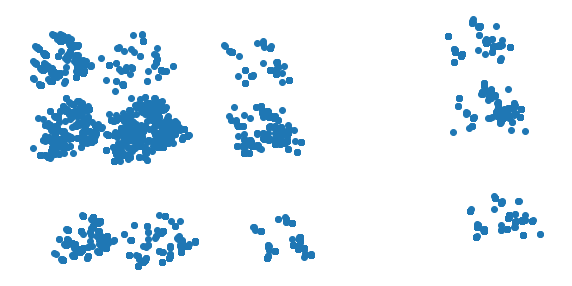

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7787 samples in 0.153s...
[t-SNE] Computed neighbors for 7787 samples in 11.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7787
[t-SNE] Computed conditional probabilities for sample 2000 / 7787
[t-SNE] Computed conditional probabilities for sample 3000 / 7787
[t-SNE] Computed conditional probabilities for sample 4000 / 7787
[t-SNE] Computed conditional probabilities for sample 5000 / 7787
[t-SNE] Computed conditional probabilities for sample 6000 / 7787
[t-SNE] Computed conditional probabilities for sample 7000 / 7787
[t-SNE] Computed conditional probabilities for sample 7787 / 7787
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.560940
[t-SNE] KL divergence after 300 iterations: 1.418763


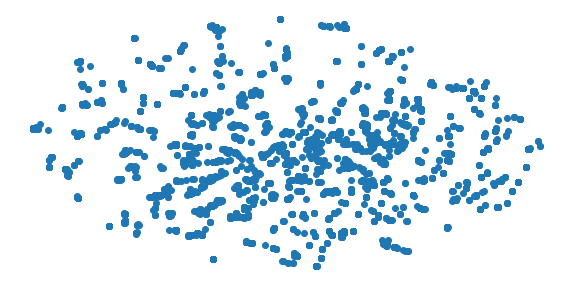

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=123)
tsne_results = tsne.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 7787 samples in 0.186s...
[t-SNE] Computed neighbors for 7787 samples in 13.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7787
[t-SNE] Computed conditional probabilities for sample 2000 / 7787
[t-SNE] Computed conditional probabilities for sample 3000 / 7787
[t-SNE] Computed conditional probabilities for sample 4000 / 7787
[t-SNE] Computed conditional probabilities for sample 5000 / 7787
[t-SNE] Computed conditional probabilities for sample 6000 / 7787
[t-SNE] Computed conditional probabilities for sample 7000 / 7787
[t-SNE] Computed conditional probabilities for sample 7787 / 7787
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.288391
[t-SNE] KL divergence after 300 iterations: 1.232481


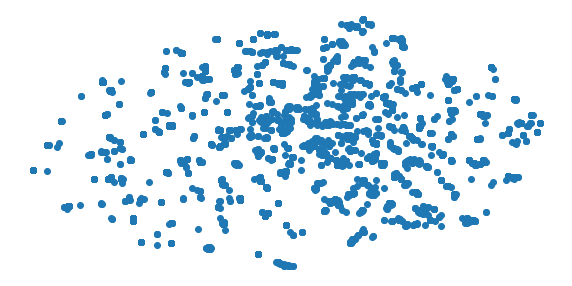

In [29]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=300)
tsne_results = tsne.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7787 samples in 0.187s...
[t-SNE] Computed neighbors for 7787 samples in 9.558s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7787
[t-SNE] Computed conditional probabilities for sample 2000 / 7787
[t-SNE] Computed conditional probabilities for sample 3000 / 7787
[t-SNE] Computed conditional probabilities for sample 4000 / 7787
[t-SNE] Computed conditional probabilities for sample 5000 / 7787
[t-SNE] Computed conditional probabilities for sample 6000 / 7787
[t-SNE] Computed conditional probabilities for sample 7000 / 7787
[t-SNE] Computed conditional probabilities for sample 7787 / 7787
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.682381
[t-SNE] KL divergence after 300 iterations: 1.611513


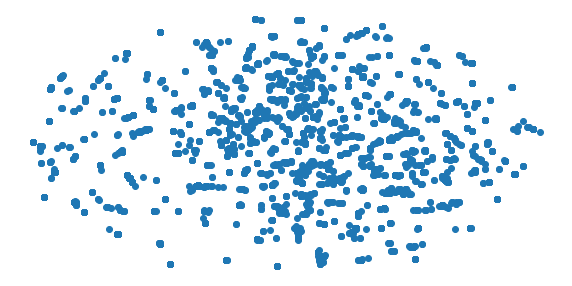

In [30]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib

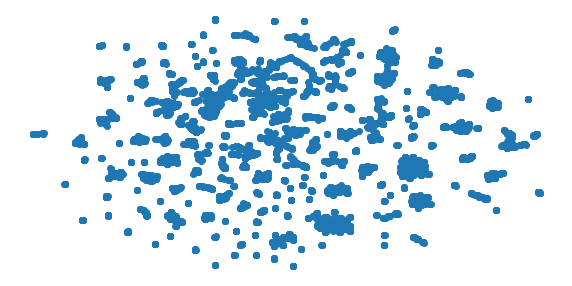

In [31]:
umap_results = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

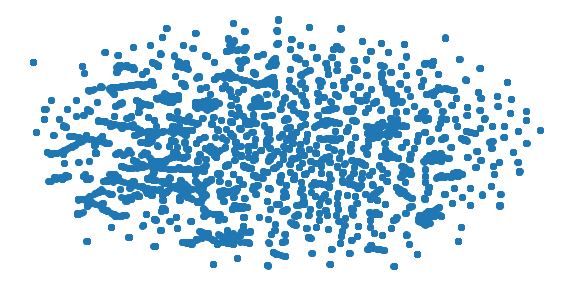

In [32]:
umap_results = umap.UMAP(n_neighbors=3, min_dist=0.3, metric='correlation').fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

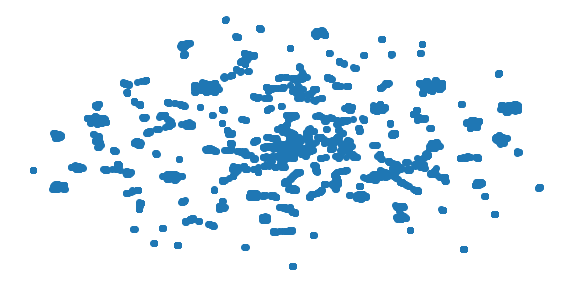

In [33]:
umap_results = umap.UMAP(n_neighbors=7, min_dist=0.3, metric='correlation').fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [34]:
#the components of the different dimensionality reduction techniques doesn't have a ground truth to be compared to
#Given this, it looks like PCA has the most clear separation between clusters, so I will be using PCA

In [35]:
pca = PCA(n_components=2, random_state=123)
pca_components = pca.fit_transform(netflix)

In [42]:
clusters=0
best=0
for i in range(2,15):
  labels = KMeans(n_clusters=i, random_state=123).fit_predict(pca_components)
  sil=metrics.silhouette_score(pca_components, labels, metric='euclidean')
  if sil>best:
    best=sil
    clusters=i
print('The Silhuette score with {} clusters is {}'.format(clusters, best))

The Silhuette score with 10 clusters is 0.6906403251845316


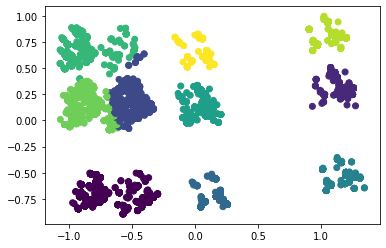

In [45]:
cluster= KMeans(n_clusters=10, random_state=123)

y_pred = cluster.fit_predict(pca_components)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y_pred)
plt.show()

In [46]:
from sklearn.cluster import AgglomerativeClustering

linkage_methods = ["ward", "average", "complete"]
for i in linkage_methods:
  try:
    agg_cluster = AgglomerativeClustering(linkage=i, 
                                        affinity='cosine',
                                        n_clusters=10)


    clusters = agg_cluster.fit_predict(pca_components)

    print("Silhouette score of linkage method {}: {}".format(i,metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
    print("------------------------------------------------")

  except:
    agg_cluster = AgglomerativeClustering(linkage=i, 
                                      affinity='euclidean',
                                      n_clusters=10)


    clusters = agg_cluster.fit_predict(pca_components)

    print("Silhouette score of linkage method {}: {}".format(i,metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
    print("------------------------------------------------")


Silhouette score of linkage method ward: 0.6886701972833837
------------------------------------------------
Silhouette score of linkage method average: 0.46022640440432117
------------------------------------------------
Silhouette score of linkage method complete: 0.39268825451914335
------------------------------------------------


In [47]:
#It looks like the best linkage method is ward, so I will try to tune some parameters in there to get a better score
best=0
n_clusters=0
for i in range(2,15):
  agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=i)


  clusters = agg_cluster.fit_predict(pca_components)

  score=metrics.silhouette_score(pca_components, clusters, metric='euclidean')

  if score>best:
    best=score
    n_clusters=i
  else:
    continue

print("Silhouette score of linkage method ward and {} clusters: {}".format(n_clusters,best))
print("------------------------------------------------")

Silhouette score of linkage method ward and 10 clusters: 0.6886701972833837
------------------------------------------------


In [48]:
from sklearn.mixture import GaussianMixture

types=['full', 'tied', 'diag','spherical']
for i in types:
  gmm_cluster = GaussianMixture(n_components=10, random_state=123, covariance_type=i)

  clusters = gmm_cluster.fit_predict(pca_components)

  print("Silhouette score with covariance_type={}: {}".format(i,metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
  print("------------------------------------------------------")

Silhouette score with covariance_type=full: 0.600016923552233
------------------------------------------------------
Silhouette score with covariance_type=tied: 0.6497564433743369
------------------------------------------------------
Silhouette score with covariance_type=diag: 0.6336839826817618
------------------------------------------------------
Silhouette score with covariance_type=spherical: 0.6474112068589926
------------------------------------------------------


In [52]:
n_clusters=0
best=0
for i in range(2,15):
  gmm_cluster = GaussianMixture(n_components=i, random_state=123, covariance_type='tied')

  clusters = gmm_cluster.fit_predict(pca_components)
  sil=metrics.silhouette_score(pca_components, clusters, metric='euclidean')
  if sil>best:
    best=sil
    n_clusters=i
print('The Silhuette score with {} clusters is {}'.format(n_clusters, best))

The Silhuette score with 8 clusters is 0.681559492315821


Discussion:

Given the silhouette scores, we can reasonably cluster the cleaned netflix dataset using either K-means, agglomerative clustering, or gaussian mixtures. However, the clustering ability for this model can still be improved by further data exploration and feature engineering. Some of the less important features can be removed from this dataset and others can be utilized. In the future, the description feature can be utilized to cluster the data set using word similarity across the different titles.
